In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [142]:
drds=0.8
drdt=-1

In [143]:
Tl = np.zeros( (3,2) )
Tr = np.zeros( (3,2) )
zl = np.zeros( (3,2) )
zr = np.zeros( (3,2) )

In [157]:
Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [22,18]
Tr[1,:] = [18,14]
Tr[2,:] = [14,10]

Tl[0,:] = [22,18]
Tl[1,:] = [18,14]
Tl[2,:] = [14,10]
Tr[0,:] = [20,16]
Tr[1,:] = [16,12]
Tr[2,:] = [12,8]

nk = 3
hl = np.ones( nk )*10
hr = np.ones( nk )*10
ns = 3*4

zl[0,0] = 0
zr[0,0] = 0
zl[0,1] = hl[0]
zr[0,1] = hr[0]

for k in range(1,nk):
  zl[k,0] = zl[k-1,1]
  zl[k,1] = zl[k,0] + hl[k]
  zr[k,0] = zr[k-1,1]
  zr[k,1] = zr[k,0] + hr[k]
  
point_left = np.zeros(ns)

In [165]:
def calc_drho( T1, drdt1, T2, drdt2 ):
  if T1 == T2:
    return 0
  else:
    return 0.5*(drdt1 + drdt2)*( T1 - T2 )
def find_pos(drhoneg, drhopos):
  if drhopos - drhoneg > 0:
    pos = -drhoneg/(drhopos-drhoneg)
  elif drhopos-drhoneg  == 0.:
    if drhoneg > 0.:
      pos = 0.
    else:
      pos = 1.
  if (pos < 0) or (pos > 1):
    print("SOMETHING WENT WRONG",pos)
  return pos
def abs_pos(zl,kl,pos):
  kl = np.int(kl)
  return zl[kl,0]*(1-pos) + zl[kl,1]*pos
  

In [166]:
ki_left = 0 ; ki_right = 0
kl_left = 0 ; kl_right = 0
reached_bottom = False
searching_left_column  = True
searching_right_column = True
PoL = np.zeros( ns )
PoR = np.zeros( ns )
KoL = np.zeros( ns )
KoR = np.zeros( ns )

# For the first surface we just need to figure out which top interface is lighter
drho = calc_drho(Tl[0,0], drdt, Tr[0,0], drdt)

for ksurf in range(0,ns):
  # Need to check the interfaces of each side to see which direction we should search
  drho = calc_drho(Tr[kl_right,ki_right], drdt, Tl[kl_left,ki_left], drdt)
  print("drho: %f Tl[%d,%d]: %f, Tr[%d,%d]: %f" % (drho, kl_left,ki_left,Tl[kl_left,ki_left],
                                                   kl_right,ki_right,Tr[kl_right,ki_right]))
    
  if not reached_bottom:
    if drho < 0:
      print("drho < 0: Search left")
      searching_left_column  = True
      searching_right_column = False
    elif drho > 0:
      print("drho > 0: Search right")
      searching_left_column  = False
      searching_right_column = True
    else:
      if (kl_left == 0) and (kl_right == 0) and ((ki_left + ki_right) == 0):
        print("drho = 0: At surface")
        searching_left_column  = True
        searching_right_column = False
      else:
        print("drho = 0: Switch direction")
        searching_left_column  = not searching_left_column
        searching_right_column = not searching_right_column
  if searching_left_column:
    # The position of the interface we're searching from is now known
    PoR[ksurf] = ki_right
    KoR[ksurf] = kl_right
    
    # Figure out whether the layer is stable relative to the interface
    T_ref = Tr[kl_right,ki_right]
    drhotop = calc_drho(Tl[kl_left,0], drdt, T_ref, drdt)
    drhobot = calc_drho(Tl[kl_left,1], drdt, T_ref, drdt)

    # Set the position on the left column
    if drhotop > 0. or ksurf == 0:
      PoL[ksurf] = 0.
    elif drhotop >= drhobot:
      PoL[ksurf] = 1.
    else:
      PoL[ksurf] = find_pos(drhotop,drhobot)
    KoL[ksurf] = kl_left
    
    # Check if we've reached the bottom, otherwise increment the interface/layer
    reached_bottom = (kl_left == nk-1) and (ki_left == 1)
    if reached_bottom:
      searching_right_column = True
      searching_left_column  = False
    else:
      if ki_right == 1:
        kl_right = kl_right + 1
        ki_right = 0
      else:
        ki_right = 1
    point_left[ksurf] = True
    print("\tSearch left")
    print("\t\t Temp right: %f" % T_ref)
    print("\t\t Temp left top: %f" % Tl[kl_left,0])
    print("\t\t Temp left bot: %f" % Tl[kl_left,1])
    print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
    print("\t\t PoL: %f" % PoL[ksurf])

  if searching_right_column:
    # The position of the interface we're searching from is now known
    PoL[ksurf] = ki_left
    KoL[ksurf] = kl_left
    
    # Figure out whether the layer is stable relative to the interface
    T_ref = Tr[kl_left,ki_left]
    drhotop = calc_drho(Tl[kl_right,0], drdt, T_ref, drdt)
    drhobot = calc_drho(Tl[kl_right,1], drdt, T_ref, drdt)

    # Set the position on the left column
    if drhotop > 0. or ksurf == 0:
      PoR[ksurf] = 0.
    elif drhotop >= drhobot:
      PoR[ksurf] = 1.
    else:
      PoR[ksurf] = find_pos(drhotop,drhobot)
    KoR[ksurf] = kl_right
    
    # Check if we've reached the bottom, otherwise increment the interface/layer
    reached_bottom = (kl_left == nk-1) and (ki_left == 1)
    if reached_bottom:
      searching_right_column = False
      searching_left_column  = True
    else:
      if ki_left == 1:
        kl_left = kl_left + 1
        ki_left = 0
      else:
        ki_left = 1 
    point_left[ksurf] = False
    print("\tSearch right")
    print("\t\t Temp left: %f" % T_ref)
    print("\t\t Temp right top: %f" % Tr[kl_right,0])
    print("\t\t Temp right bot: %f" % Tr[kl_right,1])
    print("\t\t drhotop: %f drhobot: %f" % (drhotop, drhobot))
    print("\t\t PoR: %f" % PoR[ksurf])

drho: 2.000000 Tl[0,0]: 22.000000, Tr[0,0]: 20.000000
drho > 0: Search right
	Search right
		 Temp left: 20.000000
		 Temp right top: 20.000000
		 Temp right bot: 16.000000
		 drhotop: -2.000000 drhobot: 2.000000
		 PoR: 0.000000
drho: -2.000000 Tl[0,1]: 18.000000, Tr[0,0]: 20.000000
drho < 0: Search left
	Search left
		 Temp right: 20.000000
		 Temp left top: 22.000000
		 Temp left bot: 18.000000
		 drhotop: -2.000000 drhobot: 2.000000
		 PoL: 0.500000
drho: 2.000000 Tl[0,1]: 18.000000, Tr[0,1]: 16.000000
drho > 0: Search right
SOMETHING WENT WRONG 1.5
	Search right
		 Temp left: 16.000000
		 Temp right top: 20.000000
		 Temp right bot: 16.000000
		 drhotop: -6.000000 drhobot: -2.000000
		 PoR: 1.500000
drho: 2.000000 Tl[1,0]: 18.000000, Tr[0,1]: 16.000000
drho > 0: Search right
SOMETHING WENT WRONG 1.5
	Search right
		 Temp left: 16.000000
		 Temp right top: 20.000000
		 Temp right bot: 16.000000
		 drhotop: -6.000000 drhobot: -2.000000
		 PoR: 1.500000
drho: -2.000000 Tl[1,1]: 14.00

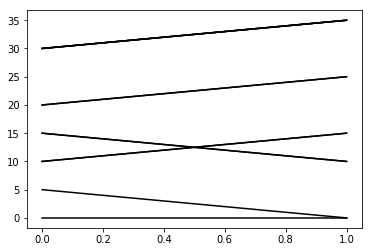

In [167]:
plt.figure()
for ks in range(0,ns):
  if point_left[ksurf]:
    x0 = 1
    y0 = abs_pos( zr, KoR[ks], PoR[ks] )
    x1 = 0
    y0 = abs_pos( zl, KoL[ks], PoL[ks] )
  else:
    x0 = 0
    y0 = abs_pos( zl, KoL[ks], PoL[ks] )
    x1 = 1
    y1 = abs_pos( zr, KoR[ks], PoR[ks] )
  plt.plot([x0,x1],[y0,y1],'k')

In [161]:
output = pd.DataFrame( {'KoL':KoL,'PoL':PoL,'KoR':KoR,'PoR':PoR } )
print(output)

    KoL  KoR  PoL  PoR
0   0.0  0.0  0.0  0.0
1   0.0  0.0  0.0  0.5
2   0.0  0.0  0.5  0.0
3   0.0  0.0  1.0  1.5
4   1.0  0.0  0.0  1.5
5   1.0  0.0  0.5  1.0
6   1.0  1.0  0.5  0.0
7   1.0  1.0  1.0  1.5
8   2.0  1.0  0.0  1.5
9   2.0  1.0  1.0  2.5
10  2.0  1.0  1.0  2.5
11  2.0  1.0  1.0  2.5
